# Midori: A Block Cipher for Low Energy

---


# 1- Implementation
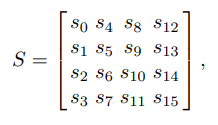


### a- Key Generation
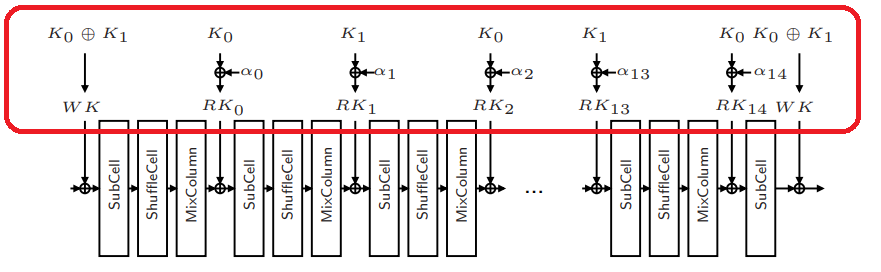

In [1]:
from array import *
beta=[[0,0,0,1,0,1,0,1,1,0,1,1,0,0,1,1],[0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0],
                [1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,1],[0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1],
                [0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1],[1,1,0,1,0,0,0,1,0,1,1,1,0,0,0,0],
                [0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0],[0,0,0,0,1,0,1,1,1,1,0,0,1,1,0,0],
                [1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1],[0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0],
                [0,1,1,1,0,0,0,1,1,0,0,1,0,1,1,1],[0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0],
                [0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0],[1,1,1,1,1,0,0,0,1,1,0,0,1,0,1,0],
                [1,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0]]                
 
def KeyGen(key_128bit):
    K0 = stringToHexList(key_128bit[:16])
    K1 = stringToHexList(key_128bit[16:32])
    WK = list(int(a,16)^int(b,16) for a,b in zip(K0,K1))  
    for i in range(0,16):
        WK[i]=hex(WK[i])
    return WK,K0,K1

### b- Key Add
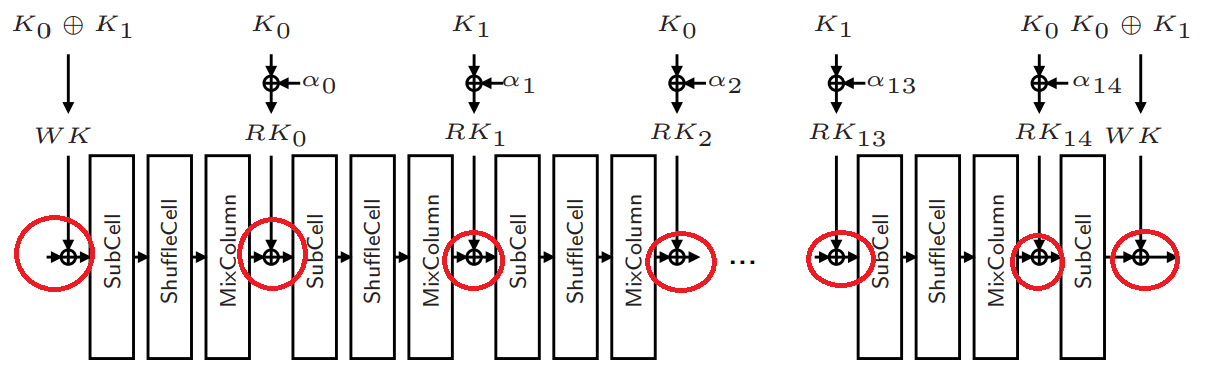

In [2]:
def KeyAdd (state, key, iteration):
    if (iteration == -1):
        state = list(int(str(a),16)^int(str(b),16) for a, b in zip(key, state))
        for i in range(0, 16):
            state[i] = hex(state[i])
    else:
        k = list(int(str(a),16) ^ int(b) for a, b in zip(beta[iteration], key))
        state = list(int(str(a),16) ^ int(b) for a, b in zip(state, k))
        for i in range(0, 16):
            state[i] = hex(state[i])
    return state

## c- Sub Cell 
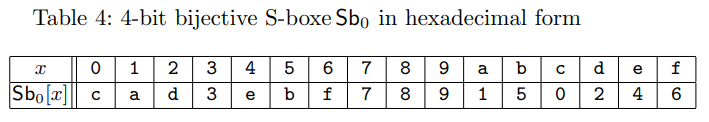

In [3]:
Sb0 = [0xc,0xa,0xd,0x3,0xe,0xb,0xf,0x7,0x8,0x9,0x1,0x5,0x0,0x2,0x4,0x6]
def SubCell(state):
    for i in range(16):
        state[i] = hex(Sb0[int(str(state[int(i)]),16)])
    return state

## d- Shuffle Cell
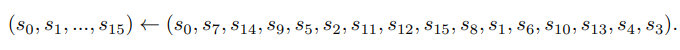

In [4]:
def ShuffleCell(state):
    newIndices=[0,10,5,15,14,4,11,1,9,3,12,6,7,13,2,8]
    tempState = state[:]
    for i in range(16):
        tempState[i]= state[newIndices[i]]
    return tempState

## e- Mix Column
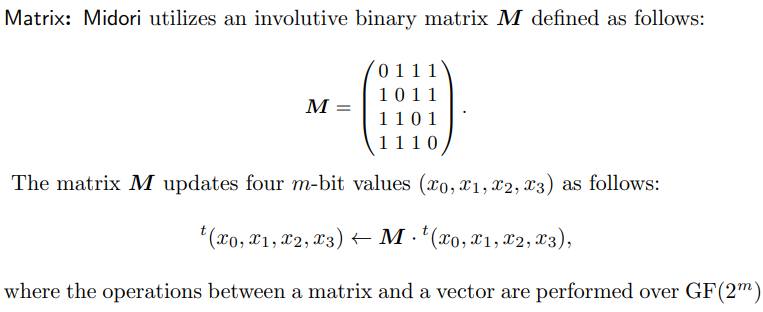

In [5]:
def MixColumn(state):
    cell = state[0:16]  
    for i in range(0,4):
            state[i*4]=hex(int(str(cell[i*4+1]),16) ^ int(str(cell[i*4+2]),16)^int(str(cell[i*4+3]),16))
            state[i*4+1]=hex(int(str(cell[i*4]),16) ^ int(str(cell[i*4+2]),16)^int(str(cell[i*4+3]),16))
            state[i*4+2]=hex(int(str(cell[i*4]),16) ^ int(str(cell[i*4+1]),16)^int(str(cell[i*4+3]),16))
            state[i*4+3]=hex(int(str(cell[i*4]),16) ^ int(str(cell[i*4+1]),16)^int(str(cell[i*4+2]),16))
    return state

## f- Round Function
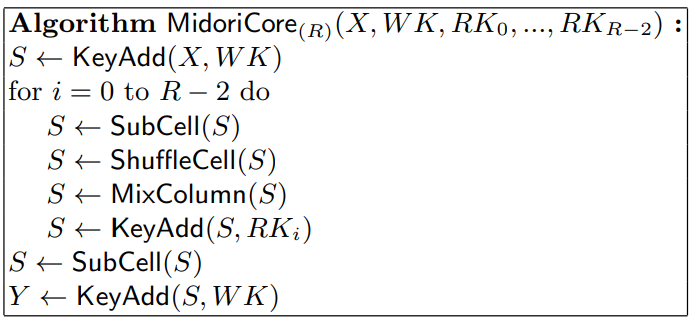

In [6]:
def Midori64_Core(plainText, WK, K0, K1):
    S = KeyAdd(plainText, WK,-1)
    for i in range(15):
        S = SubCell(S)
        S = ShuffleCell(S)
        S = MixColumn(S)
        S = KeyAdd(S, stringToIntList(K0 if i%2==0 else K1), i)
    S = SubCell(S)
    Y = KeyAdd(S, WK,-1)
    return Y

# 2- Test Suite

##### Utility Functions

In [7]:
def stringToHexList(string_input):
    hex_list = []
    for i in range(len(string_input)):
        hex_list.append(hex(int(str(string_input[i]),16)))
    return hex_list
 
def stringToIntList(string_input):
    int_list = []
    for i in range(len(string_input)):
        int_list.append(int(str(string_input[i]),16))
    return int_list

In [8]:
import unittest
class Test_Midori64(unittest.TestCase):

    def test_KeyGen(self):
        K0 = "687ded3b3c85b3f3" 
        K1 = "5b1009863e2a8cbf"
        WK = "336de4bd02af3f4c"
        key_128bit = K0+K1
        expected_output = (stringToHexList(WK), stringToHexList(K0), stringToHexList(K1))
        self.assertEqual(expected_output, KeyGen(key_128bit))

 
    def test_KeyAdd(self):
        # Before Round 0
        state = "42c20fd3b586879e"
        WK = "336de4bd02af3f4c"
        iteration = -1
        expected_output = stringToHexList("71afeb6eb729b8d2")
        self.assertEqual(expected_output, KeyAdd(stringToHexList(state), stringToHexList(WK), iteration))

        # Round 0
        K0 = "687ded3b3c85b3f3"
        state = "5f7f71cfcde4c09d"
        expected_output = stringToHexList("37039df5e170737f")
        self.assertEqual(expected_output, KeyAdd(stringToHexList(state), stringToIntList(K0),0))

        #Round 1
        K1 = "5b1009863e2a8cbf"
        state = "37262c922bfeb3c4"
        expected_output = stringToHexList("6d27351404d43f7b")
        self.assertEqual(expected_output, KeyAdd(stringToHexList(state), stringToIntList(K1),1)) 

    def test_SubCell(self):
        # Round 0
        expected_output= "7a1645f457d9582d"
        self.assertEqual(stringToHexList(expected_output), SubCell(stringToHexList("71afeb6eb729b8d2")))

        # Round 1
        expected_output= "37c3926b4a7c7376"
        self.assertEqual(stringToHexList(expected_output), SubCell(stringToHexList("37039df5e170737f")))

        # Round 2
        expected_output= "f2d73baece2e3675"
        self.assertEqual(stringToHexList(expected_output), SubCell(stringToHexList("6d27351404d43f7b")))
 
 
    def test_ShuffleCell(self):
        # Round 0
        expected_output = "7d5d249a765f4815"
        self.assertEqual(stringToHexList(expected_output),ShuffleCell(stringToHexList("7a1645f457d9582d")))

        # Round 1
        expected_output = "372679c7a376b3c4"
        self.assertEqual(stringToHexList(expected_output),ShuffleCell(stringToHexList("37c3926b4a7c7376")))

        # Round 2
        expected_output = "f2b573e2e73ae6dc"
        self.assertEqual(stringToHexList(expected_output),ShuffleCell(stringToHexList("f2d73baece2e3675")))
 
 
    def test_MixColumn(self):
        # Round 0 
        expected_output = "5f7f71cfcde4c09d"
        self.assertEqual(stringToHexList(expected_output), MixColumn(stringToHexList("7d5d249a765f4815")))

        # Round 1
        expected_output = "37262c922bfeb3c4"
        self.assertEqual(stringToHexList(expected_output), MixColumn(stringToHexList("372679c7a376b3c4")))
 
    def test_Midori64_Core(self):
        key_128Bit = "00000000000000000000000000000000"
        WK, K0, K1 = KeyGen(key_128Bit)
        expected_output = "3c9cceda2bbd449a"
        plainText = "0000000000000000"
        self.assertEqual(stringToHexList(expected_output),Midori64_Core(plainText, WK, K0, K1))
        
        key_128Bit = "687ded3b3c85b3f35b1009863e2a8cbf"
        WK, K0, K1 = KeyGen(key_128Bit)
        expected_output = "66bcdc6270d901cd"
        plainText = "42c20fd3b586879e"
        self.assertEqual(stringToHexList(expected_output),Midori64_Core(plainText, WK, K0, K1))

In [9]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.012s

OK


# 3- Cyphering Using Midori64

In [10]:
key_128Bit = "687ded3b3c85b3f35b1009863e2a8cbf"
WK, K0, K1 = KeyGen(key_128Bit)
plainText = "42c20fd3b586879e"
expected_output = "66bcdc6270d901cd"
print("Output from Algorithm: ", *Midori64_Core(plainText, WK, K0, K1))
print("Expected Output      : ", *stringToHexList(expected_output))

Output from Algorithm:  0x6 0x6 0xb 0xc 0xd 0xc 0x6 0x2 0x7 0x0 0xd 0x9 0x0 0x1 0xc 0xd
Expected Output      :  0x6 0x6 0xb 0xc 0xd 0xc 0x6 0x2 0x7 0x0 0xd 0x9 0x0 0x1 0xc 0xd
